# Bike sharing analysis
Group Assignment - **Section 1 Group D** - *Submitted: 26.03.2022*

![Bike](https://i0.wp.com/enjoymiamibeach.com/wp-content/uploads/2016/07/citi-bike-rental-miami-beach-2.jpg?ssl=1)

### Table of Contents:
1. Introduction
2. Exploratory analysis
3. Feature engineering
4. Data visualization
5. ML predictive analytics

---
## 1. Introduction

The goal of this analysis is to perform an extensive EDA on the underlying dataset of of Washington D.C. bicycle users and provides insights for modeling Bike-Sharing rentals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
from ipywidgets import interact
import matplotlib.dates as mdates

import sklearn
from sklearn.compose import (ColumnTransformer, make_column_transformer, make_column_selector)
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, StandardScaler, RobustScaler)
from sklearn.impute import (SimpleImputer, KNNImputer)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import r2_score

In [2]:
import warnings
# warnings.filterwarnings('ignore')

In [3]:
seed = 49

In [4]:
sns.set()

In [5]:
# importing the dataset, set index column and parse the dates:

df = pd.read_csv("hour.csv", index_col = "instant", parse_dates=["dteday"])

---
## 2. Exploratory analysis

In [6]:
df.describe()

hr          temp         atemp           hum     windspeed  \
count  17379.000000  17280.000000  17279.000000  17279.000000  17279.000000   
mean      11.546752      0.497071      0.475530      0.627235      0.190114   
std        6.914405      0.192474      0.171782      0.193047      0.122378   
min        0.000000      0.020000      0.000000      0.000000      0.000000   
25%        6.000000      0.340000      0.333300      0.480000      0.104500   
50%       12.000000      0.500000      0.484800      0.630000      0.194000   
75%       18.000000      0.660000      0.621200      0.780000      0.253700   
max       23.000000      1.000000      1.000000      1.000000      0.850700   

             casual    registered           cnt  
count  17379.000000  17379.000000  17379.000000  
mean      35.676218    153.786869    189.463088  
std       49.305030    151.357286    181.387599  
min        0.000000      0.000000      1.000000  
25%        4.000000     34.000000     40.000000  
50%       17.000000    115.000000    142.000000  
75%       48.000000    220.000000    281.000000  
max      367.000000    886.000000    977.000000

In [7]:
df.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [8]:
df.isnull().sum()

dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

In [9]:
# Handle NaN in chapter 5 through Imputer function

In [10]:
# Check if defined index is working properly
df.index.is_unique

True

In [11]:
# Check if defined index is working properly
df.index.is_monotonic_increasing

True

---
## 3. Feature engineering

In [12]:
# Split the given date column into year, month, day and weekday to engineer more insightful features

df['year'] = pd.DatetimeIndex(df['dteday']).year
df['month'] = pd.DatetimeIndex(df['dteday']).month
df['day'] = pd.DatetimeIndex(df['dteday']).day
df['weekday'] = pd.DatetimeIndex(df['dteday']).weekday
df.tail()

dteday  hr                                         weathersit  \
instant                                                                     
17375   2012-12-31  19  Mist + Cloudy, Mist + Broken clouds, Mist + Fe...   
17376   2012-12-31  20  Mist + Cloudy, Mist + Broken clouds, Mist + Fe...   
17377   2012-12-31  21    Clear, Few clouds, Partly cloudy, Partly cloudy   
17378   2012-12-31  22    Clear, Few clouds, Partly cloudy, Partly cloudy   
17379   2012-12-31  23    Clear, Few clouds, Partly cloudy, Partly cloudy   

         temp   atemp   hum  windspeed  casual  registered  cnt  year  month  \
instant                                                                        
17375    0.26  0.2576  0.60     0.1642      11         108  119  2012     12   
17376    0.26  0.2576  0.60     0.1642       8          81   89  2012     12   
17377    0.26  0.2576  0.60     0.1642       7          83   90  2012     12   
17378    0.26  0.2727  0.56     0.1343      13          48   61  2012     12   
17379    0.26  0.2727  0.65     0.1343      12          37   49  2012     12   

         day  weekday  
instant                
17375     31        0  
17376     31        0  
17377     31        0  
17378     31        0  
17379     31        0

In [13]:
# Define a new binary feature to separate weekdays from weekends 

df['weekend'] = np.where(df['weekday'].isin([5, 6]), 1, 0)

In [14]:
# Define a new feature to to cluster the data into four seasons 
# first is month
# second is season
#for loop going through the month column for each row
seasons = {1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1}
df['season'] = df['month'].apply(lambda x: seasons[x])

In [15]:
# Define a new binary feature to separate holidays 
# only import calendar
# 2 years worth of data
# put yes or no if it is a holiday
# matches the format of each date == pydate
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2011-01-01', end='2012-12-31').to_pydatetime()
df['holiday'] = np.where(df["dteday"].isin(holidays), 1, 0)

us_holidays_list = []
for date in holidays.UnitedStates(years=[2011, 2012]).items():
    us_holidays_list.append(str(date[0]))

df['holiday'] = np.where(df['dteday'].isin(us_holidays_list), 1, 0)

In [16]:
# Define a new binary feature to define certain rushhours periods in the morning and afternoon/evening 

df['rushhour'] = np.where(df['hr'].isin([7, 8, 16, 17, 18, 19]), 1, 0)

In [17]:
# Overview of modified dataframe before entering visualizational and ML prediction phase 
df

dteday  hr                                         weathersit  \
instant                                                                     
1       2011-01-01   0    Clear, Few clouds, Partly cloudy, Partly cloudy   
2       2011-01-01   1    Clear, Few clouds, Partly cloudy, Partly cloudy   
3       2011-01-01   2    Clear, Few clouds, Partly cloudy, Partly cloudy   
4       2011-01-01   3    Clear, Few clouds, Partly cloudy, Partly cloudy   
5       2011-01-01   4    Clear, Few clouds, Partly cloudy, Partly cloudy   
...            ...  ..                                                ...   
17375   2012-12-31  19  Mist + Cloudy, Mist + Broken clouds, Mist + Fe...   
17376   2012-12-31  20  Mist + Cloudy, Mist + Broken clouds, Mist + Fe...   
17377   2012-12-31  21    Clear, Few clouds, Partly cloudy, Partly cloudy   
17378   2012-12-31  22    Clear, Few clouds, Partly cloudy, Partly cloudy   
17379   2012-12-31  23    Clear, Few clouds, Partly cloudy, Partly cloudy   

         temp   atemp   hum  windspeed  casual  registered  cnt  year  month  \
instant                                                                        
1        0.24  0.2879  0.81     0.0000       3          13   16  2011      1   
2        0.22  0.2727  0.80     0.0000       8          32   40  2011      1   
3        0.22  0.2727  0.80     0.0000       5          27   32  2011      1   
4        0.24  0.2879  0.75     0.0000       3          10   13  2011      1   
5        0.24  0.2879  0.75     0.0000       0           1    1  2011      1   
...       ...     ...   ...        ...     ...         ...  ...   ...    ...   
17375    0.26  0.2576  0.60     0.1642      11         108  119  2012     12   
17376    0.26  0.2576  0.60     0.1642       8          81   89  2012     12   
17377    0.26  0.2576  0.60     0.1642       7          83   90  2012     12   
17378    0.26  0.2727  0.56     0.1343      13          48   61  2012     12   
17379    0.26  0.2727  0.65     0.1343      12          37   49  2012     12   

         day  weekday  weekend  season  holiday  rushhour  
instant                                                    
1          1        5        1       1        0         0  
2          1        5        1       1        0         0  
3          1        5        1       1        0         0  
4          1        5        1       1        0         0  
5          1        5        1       1        0         0  
...      ...      ...      ...     ...      ...       ...  
17375     31        0        0       1        0         1  
17376     31        0        0       1        0         0  
17377     31        0        0       1        0         0  
17378     31        0        0       1        0         0  
17379     31        0        0       1        0         0  

[17379 rows x 18 columns]

---
## 4. Data visualization

---
### 4.1 Correlation

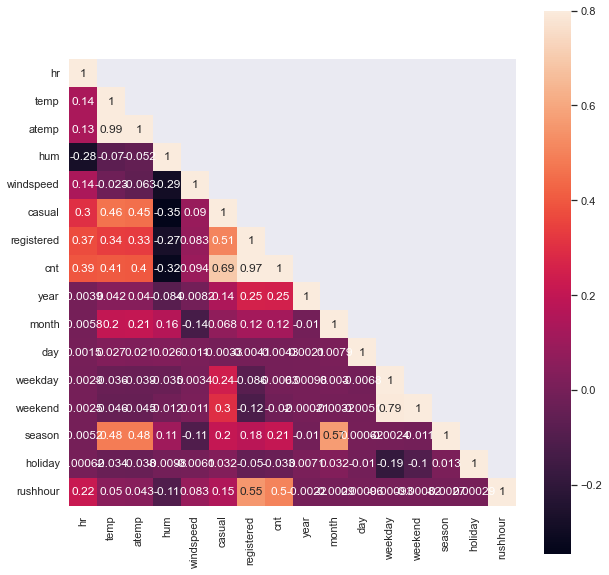

In [18]:
# Creating a correlation matrix to find highly correlated features:

# atemp (felt temp) is highly correlated with temp: 0.99 
# ride count is correlated to rushhour (0.5),  temp(0.41), atemp(0,4) and time/hr (0.39)
#  season is correlated with temp and atemp (0.48)

fig, ax = plt.subplots(figsize=(10,10))  
corrMatrix = df.corr()
mask=np.array(corrMatrix)

mask[np.tril_indices_from(mask)]=False
# shows half the matrix
#splits in triangle 

# need to make it from a dataframe to an array to use
# tril - indices which defines that we want to take out duplicates
sns.heatmap(corrMatrix,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
#only takes ahlf of the matrixs

plt.show()

## mask = mask shows only half instead of both sides
# .8 was the most that we had -- correlation
## square = rectangular dataframe
# annot = gives numbers in the squares
# ax = ax heat map uses the axes we define

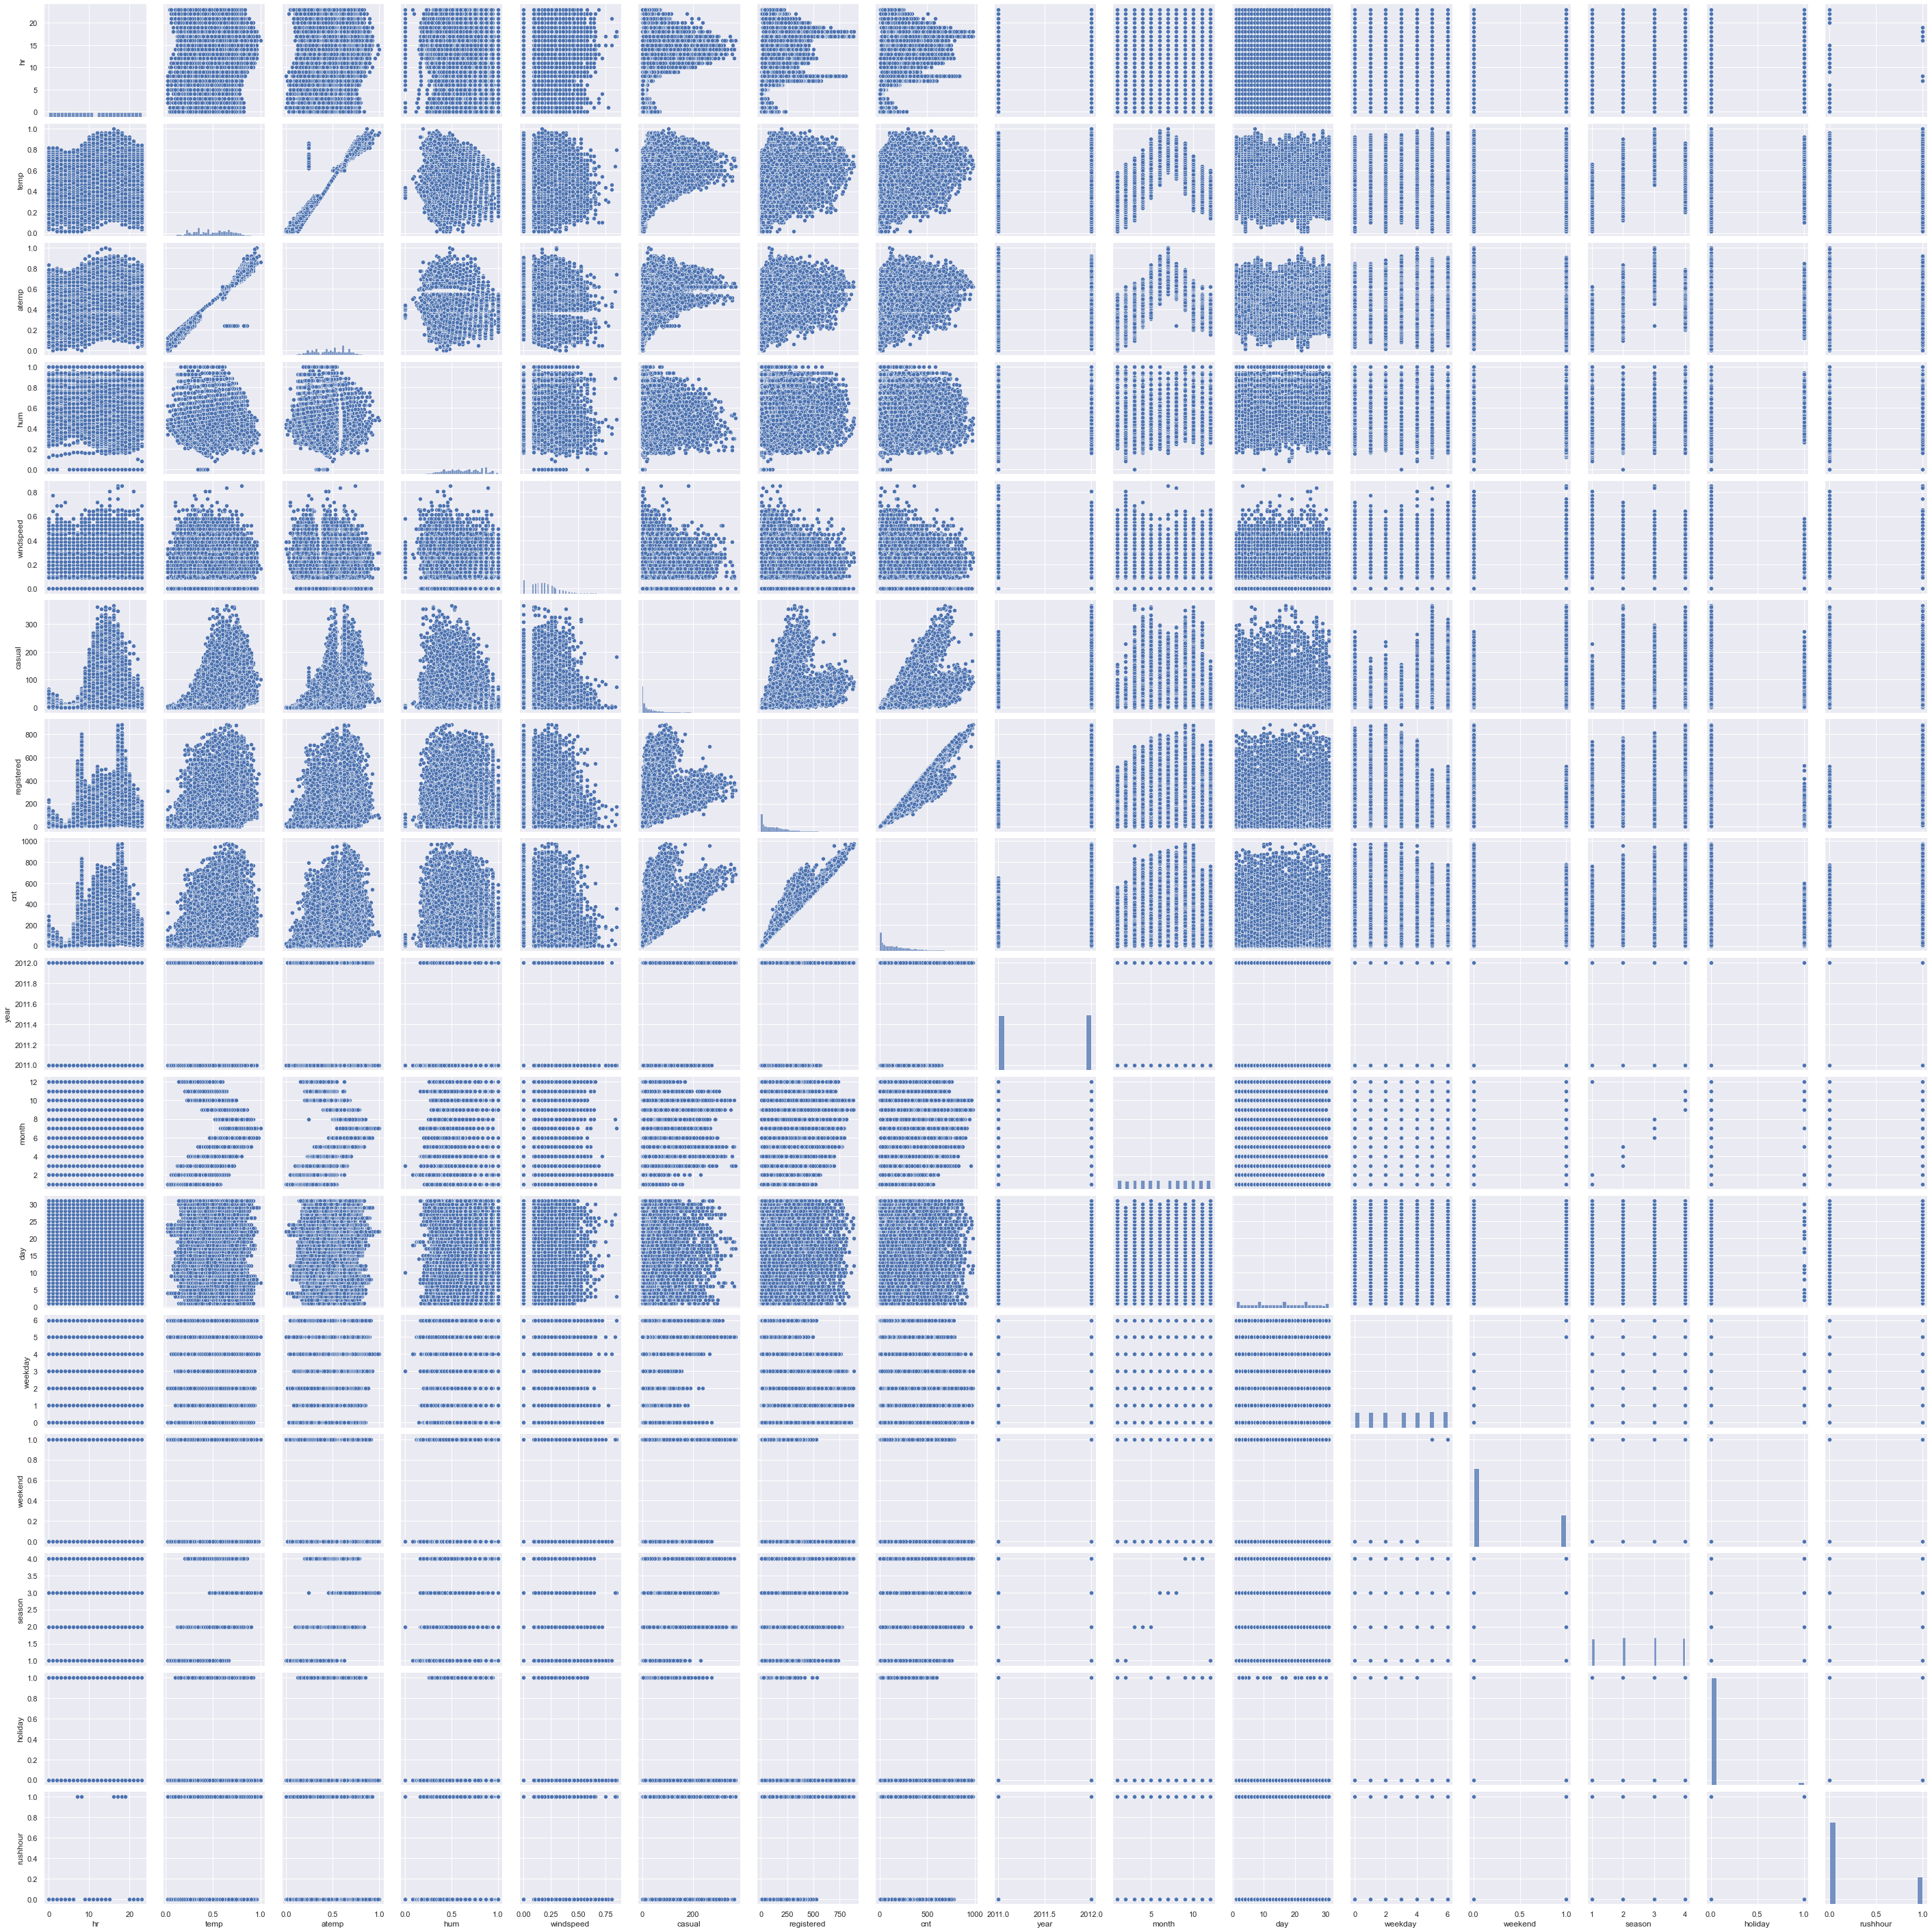

In [19]:
# Analyze shape/skew of each feature

sns.pairplot(df)

# each correlation 1 v 1

---
### 4.2 Time series per feature

In [20]:
# Further explore ride counts on different time intervals (total data, day of month, day of week, hourly):



daily_rides = df.groupby(['dteday'])['cnt'].sum() ## how many rentals per day 
dayofmonth_rides = df.groupby(['day'])['cnt'].mean() # average number of rides on each day of the month for the whole year
dayofweek_rides = df.groupby(['weekday'])['cnt'].mean() # average number of rides on each day of the week for the whole year
hour_rides = df.groupby(['hr'])['cnt'].mean() # average number of rides on each hour for the whole year

<AxesSubplot:xlabel='Date', ylabel='Ride Count'>

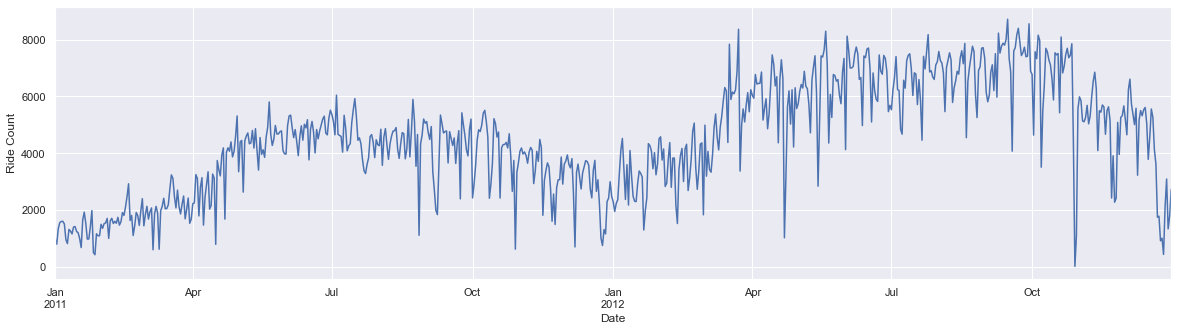

In [21]:
# In general, there seems to be a seasonal trend with higher rentals in the Summer months
# Moreover, the second year of the dataset shows a higher amount of rentals

daily_rides.plot.line(xlabel="Date", ylabel="Ride Count",figsize=(20, 5))

<AxesSubplot:xlabel='Day', ylabel='Ride Count'>

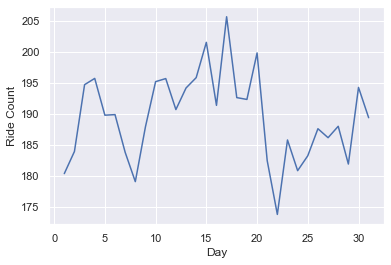

In [22]:
# On a monthly view there is a slight peak in rentals during the mid of each month

dayofmonth_rides.plot.line(xlabel="Day", ylabel="Ride Count")

<AxesSubplot:xlabel='Day', ylabel='Ride Count'>

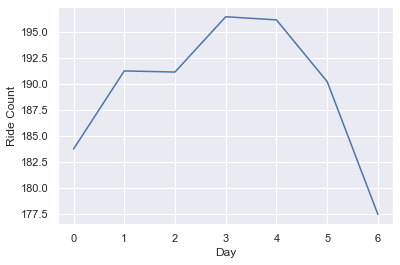

In [23]:
# On a weekly basis thursday and fridays show the highest rentals with sundays showing the minimum

dayofweek_rides.plot.line(xlabel="Day", ylabel="Ride Count")

<AxesSubplot:xlabel='Day', ylabel='Ride Count'>

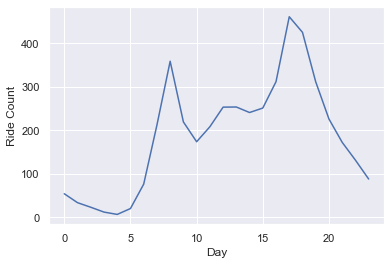

In [24]:
# On an hourly basis, peak times/rushhours can be nicely seen between 7-8 am and 4-7pm 

hour_rides.plot.line(x='hr', y='cnt', xlabel="Day", ylabel="Ride Count")

<function matplotlib.pyplot.show(close=None, block=None)>

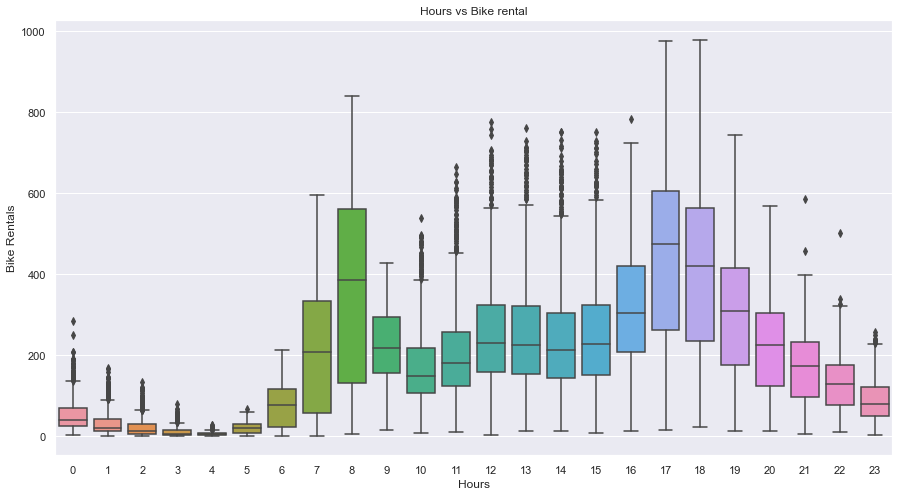

In [25]:
# When further analyzing the hourly rentals, a high amount of outliers can be found in the night hours and between 9am and 3pm 
# rentals per hour over the whole data set
# we can see the variances and outliers
# why do we have so many outliers during the day??

fig,ax=plt.subplots(figsize=(15,8))
sns.boxplot(x = "hr", y = "cnt", data = df)
plt.title("Hours vs Bike rental")
plt.xlabel("Hours")
plt.ylabel("Bike Rentals")
plt.show

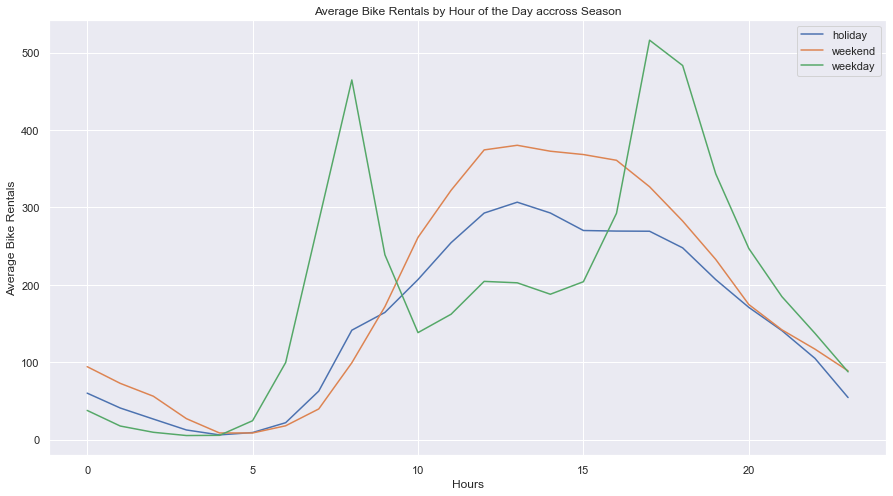

In [26]:
# We there therefore split the data into normal weekday, weekend and holiday
# This clearly shows that during weekends and holidays there are no rushhours but a high demand during the day (9am-3pm) 

avg_holiday = df.loc[df["holiday"] == 1, "cnt"].groupby(df["hr"]).mean()
avg_weekend = df.loc[df["weekend"] == 1, "cnt"].groupby(df["hr"]).mean()
avg_weekday = df.loc[df["weekend"] == 0, "cnt"].groupby(df["hr"]).mean()

# We're looking for the hours over the 2 years
# here we are finding the outliers

fig, ax = plt.subplots(figsize = (15,8))

ax.plot(df["hr"].unique(), avg_holiday, label = "holiday")
ax.plot(df["hr"].unique(), avg_weekend, label = "weekend")
ax.plot(df["hr"].unique(), avg_weekday, label = "weekday")

ax.set_xlabel("Hours")
ax.set_ylabel("Average Bike Rentals")
ax.set_title("Average Bike Rentals by Hour of the Day accross Season")

ax.legend()

# rush hour is affecting weekday 
# we have so many outliers because of holidays and weekends


# ax.set_xticks(df["hr"].unique())

---
### 4.3 Anaylsis of seasonality

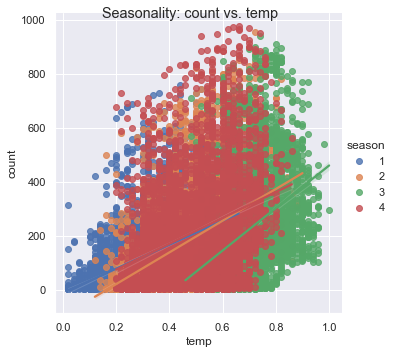

In [27]:
# Analyzing the impact of temparature, highest rentals can be found between 0.4 and 0.8 within Summer and Autumn

# we googled what we want to show and this plot is usually used for more sophisticated plots but we just chose it here
# scatterplot is also okay



sns.lmplot(x="temp", y="cnt", data=df, hue="season")
plt.suptitle("Seasonality: count vs. temp")
plt.xlabel("temp")
plt.ylabel("count");

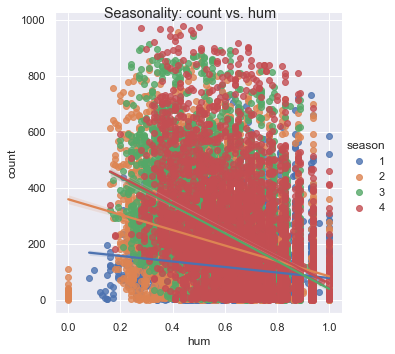

In [28]:
# Analyzing the impact of humidity, there is no big impact to be expected from this feature

sns.lmplot(x="hum", y="cnt", data=df, hue="season")
plt.suptitle("Seasonality: count vs. hum")
plt.xlabel("hum")
plt.ylabel("count");

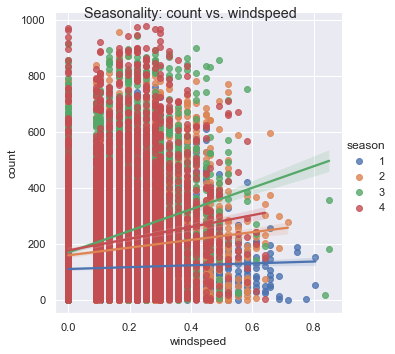

In [29]:
# Analyzing the impact of windspeed, it can be seen that rentals are unsurprisingly decreasing with higher windspeed 

sns.lmplot(x="windspeed", y="cnt", data=df, hue="season")
plt.suptitle("Seasonality: count vs. windspeed")
plt.xlabel("windspeed")
plt.ylabel("count");

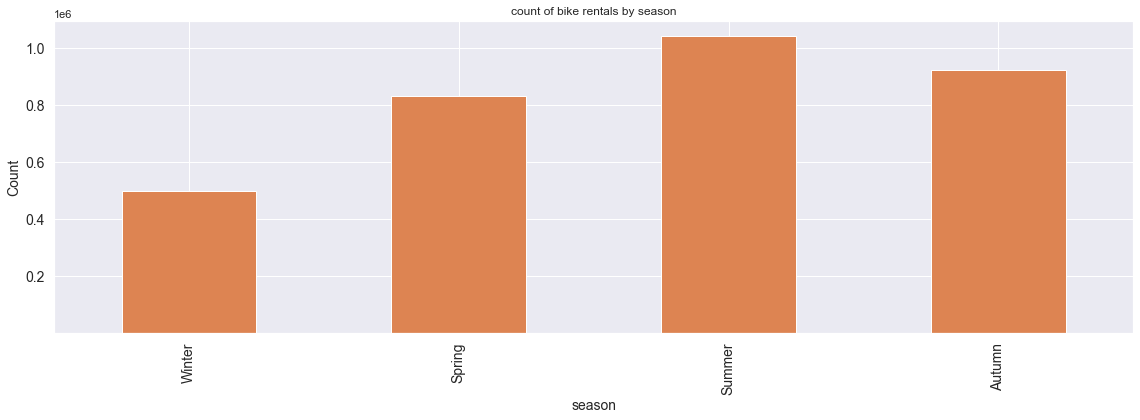

In [30]:
# Unsurprisingly, Summer and Autumn are the seasons with highest bike rentals

fig, ax  =  plt.subplots(figsize=(16, 6))

## show the 4 seasons
# and their counts
# show the difference for the 4 seasons of bike counts
# reset index has no impact now but we played with other visualizations with date as the index
# this 
# stacked makes it look nice
# false would be good for separating by season but with months

ax = df[['season','cnt']].groupby(['season']).sum().reset_index().plot(kind='bar', 
                                       legend = False, title ="count of bike rentals by season", 
                                         stacked=True, fontsize=14, ax=ax)
ax.set_xlabel("season", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_xticklabels(['Winter','Spring','Summer','Autumn'])

# puts the labels side ways

fig.tight_layout()

---
### 4.4 Anaylsis of weather

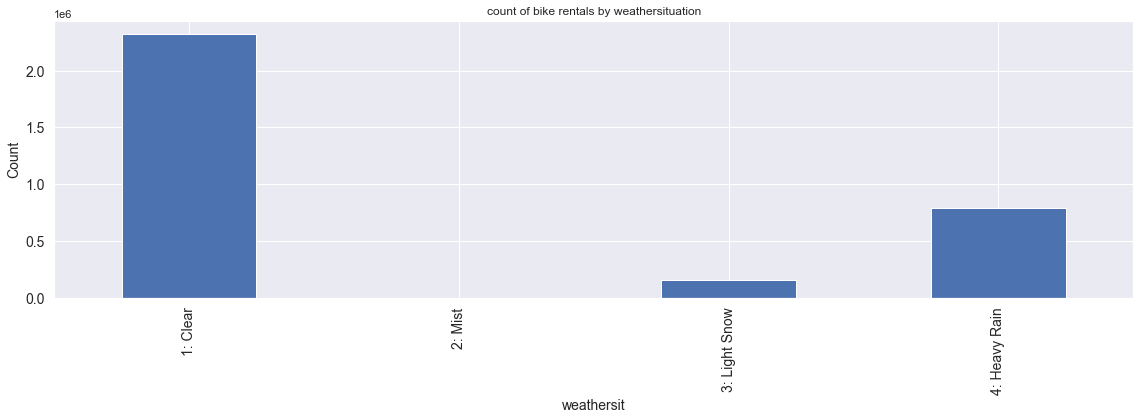

In [31]:
# Also bikes were by far rented the most when the weather was clear

fig, ax = plt.subplots(figsize=(16, 6))
 
ax = df[['weathersit','cnt']].groupby(['weathersit']).sum().reset_index().plot(kind='bar',  
      legend = False, stacked=True, title ="count of bike rentals by weathersituation", fontsize=14, ax=ax)#
ax.set_xlabel("weathersit", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_xticklabels(['1: Clear','2: Mist','3: Light Snow','4: Heavy Rain'])

# x tick label shows each bar and their name

fig.tight_layout()

In [32]:
df_hist = df[["temp", "atemp","hum","windspeed"]]

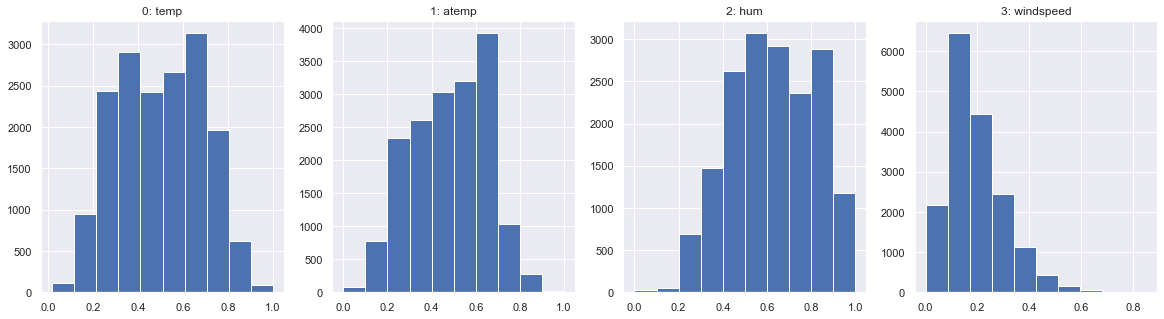

In [33]:
# Temp, atemp and hum look kind of normal distributed
# Windspeed shows a strong left-skew and might need further scaling

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes.ravel()):
    ax.hist(df_hist.iloc[:, i], bins=10)
    ax.set_title("{}: {}".format(i, df_hist.columns[i]))
    
# graphing only the 4 columns

#so the enumerate goes to the list with both variables 
# i for 0-4 and ax for the 4 features




# runs a for loop of the 4 new values i guess and keeps track of 
#each one to return them cleanly in the graph and ravel makes it 
# inot a continuous array so we dont get an error i think

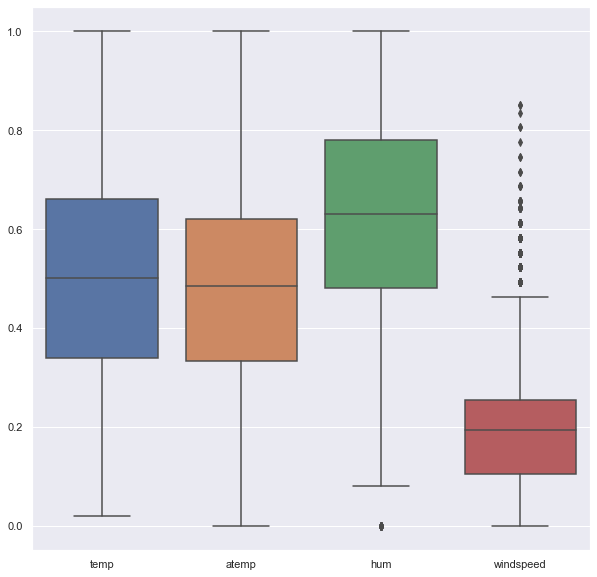

In [34]:
# Moreover, temp, atemp and hum show higher variance, while windspeed shows some outliers

sns.boxplot(data=df[['temp',
       'atemp', 'hum', 'windspeed']])
fig=plt.gcf()
fig.set_size_inches(10,10)

# gcf creates new figure
# graph modification for size, label
# object created for modification

---
## 5. ML Predictive Analytics

---
### 5.1 Model setup

In [35]:
sklearn.set_config(display="diagram")

In [36]:
# We drop features "casual" and "registered" as stated in the assignment
# We further drop the target variable "cnt" and "temp" as it is highly correlated with "atemp"
# Use log for target variable to create a simpler relationship of data to target

X = df.drop(columns=["casual", "registered", "cnt", "temp"])
y = np.log(df['cnt'])

# count is target
# temp has 100% correlation to atemp, you can switch

# target variable is log to make it more related to our features
# removing the skew


In [37]:
# Train and test datasets are splitted according the assignment description

# Use the first 3 quarters
# test is the last quarter


X_train = X.loc[X['dteday']  < '2012-10-01']
X_test = X.loc[X['dteday']  >= '2012-10-01']
y_train = y.loc[X['dteday']  < '2012-10-01'] 
y_test = y.loc[X['dteday']  >= '2012-10-01']

In [38]:
# For both datasets the date column will be dropped, as we took all relevant information from it to engineer additional features

# we need it to split but now its correlated to hour, weekday, etc

X_train = X_train.drop(columns="dteday")
X_test = X_test.drop(columns="dteday")

---
### 5.2 Pipeline setup

In [39]:
# Create a pipeline for all numerical features to impute missing values and scale them (e.g. to remove outliers) 

# Scale it and kill outliers
# just saying we are building a pipeline but don't specify yet

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy = "median"),
    RobustScaler()
)

In [40]:
# Create a pipeline for the weather feature to impute missing values and transform its string datatype

# we pick the most frequent string

weathersit_pipeline = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown="ignore"),
    SimpleImputer(strategy='most_frequent')
)   

In [41]:
# Combine both pipelines and create an additional transformation step that scales all date realted features, including: "hr", "month", "day", "weekday" and "season" 

#sparse = false computes it faster if we have an array with a lot of 0s
# in test data ignore if theres a new type
#  
# use all columns with a number
# exclude date bc it is a number
#

ct = ColumnTransformer([
    ("transform_dates", OneHotEncoder(sparse=False, handle_unknown="ignore"),["hr","month", "day", "weekday", "season"]),
    ("transform_weather", weathersit_pipeline, ["weathersit"]),
    ("impute_numerical", numerical_pipeline, make_column_selector(dtype_include="number"))
])

In [42]:
ct.fit_transform(X) #test for no error

array([[ 1.,  0.,  0., ..., -2.,  0.,  0.],
       [ 0.,  1.,  0., ..., -2.,  0.,  0.],
       [ 0.,  0.,  1., ..., -2.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  0.,  0.],
       [ 0.,  0.,  0., ..., -2.,  0.,  0.],
       [ 0.,  0.,  0., ..., -2.,  0.,  0.]])

In [43]:
# Create the final pipeline by adding a RandomForestRegressor

## putting a pipeline in place


clf = Pipeline([
    ("preprocessing", ct),
    ("regression", RandomForestRegressor())
])
clf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('transform_dates',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['hr', 'month', 'day',
                                                   'weekday', 'season']),
                                                 ('transform_weather',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['weathersit']),
                                                 ('impute_numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8008f947f0>)])),
                ('regression', RandomForestRegressor())])

In [44]:
# clf.get_params().keys()

---
### 5.3 Grid Search

#### 5.3.1 Testing different models 

In [45]:
# Set up a param_grid to test different models (with default settings) against each other

# seeing which algorithm is the best
# why tried many different ones

param_grid = [
    {
        "regression": [DecisionTreeRegressor()],
        # "preproccesing" : [StandardSclaer, Robust..]
        # "preprocessing__numerical_pipeline" : Knn imputer
    },
    {
        "regression": [RandomForestRegressor()],
    },
    {
        "regression": [AdaBoostRegressor()], 
    },
    {
        "regression": [BaggingRegressor()], 
    }
]
param_grid

[{'regression': [DecisionTreeRegressor()]},
 {'regression': [RandomForestRegressor()]},
 {'regression': [AdaBoostRegressor()]},
 {'regression': [BaggingRegressor()]}]

In [46]:
gs = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1, cv=5, scoring="r2")
gs

# cross validation 5 times
# how much perentage of target is explain by the features we chose

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('transform_dates',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['hr',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'season']),
                                                                        ('transform_weather',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer(strateg...
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f8008f947f0>)])),
                                       ('regression',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'regression': [DecisionTreeRegressor()]},
                         {'regression': [RandomForestRegressor()]},
                         {'regression': [AdaBoostRegressor()]},
                         {'regression': [BaggingRegressor()]}],
             scoring='r2')

In [47]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('transform_dates',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['hr',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'season']),
                                                                        ('transform_weather',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer(strateg...
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f8008f947f0>)])),
                                       ('regression',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'regression': [DecisionTreeRegressor()]},
                         {'regression': [RandomForestRegressor()]},
                         {'regression': [AdaBoostRegressor()]},
                         {'regression': [BaggingRegressor()]}],
             scoring='r2')

In [48]:
# Show perfomance overview of each model
# RandomForestRegressor supposed to be the best model and will be used for further hyper-parameter tuning

results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       7.601305      0.038565         0.063938        0.012315   
3       0.877751      0.033936         0.014751        0.001988   
0       0.214475      0.011042         0.010612        0.003506   
2       1.324028      0.005900         0.023568        0.003641   

          param_regression                                   params  \
1  RandomForestRegressor()  {'regression': RandomForestRegressor()}   
3       BaggingRegressor()       {'regression': BaggingRegressor()}   
0  DecisionTreeRegressor()  {'regression': DecisionTreeRegressor()}   
2      AdaBoostRegressor()      {'regression': AdaBoostRegressor()}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1           0.742413           0.926432           0.872854           0.915755   
3           0.741102           0.922320           0.858028           0.907572   
0           0.686442           0.873832           0.792335           0.809242   
2           0.776272           0.722862           0.677555           0.720446   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
1           0.932598         0.878011        0.070940                1  
3           0.927164         0.871237        0.069523                2  
0           0.867165         0.805803        0.067577                3  
2           0.565501         0.692527        0.070813                4

#### 5.3.2 Testing hyperparameters for best performing model

In [49]:
# clf.get_params().keys()

In [50]:
# Set up another param_grid that is finetuning the selected model
# Due to processing performance we only selected the best performing parameters for the final submission

# now we know RF is the best and are running different hyperparameters
# we just the ones we used in the end


param_grid = [
    {
        "regression": [RandomForestRegressor()],
        "regression__max_depth": [10],   # np.linspace(15, 20, num=5, dtype = int)
        "regression__n_estimators": [30], # np.linspace(40, 60, num=20, dtype = int)
        "regression__max_features": [0.7], # np.linspace(0.6, 0.8, num=5)
        "regression__random_state": [seed],
    }
]
param_grid

[{'regression': [RandomForestRegressor()],
  'regression__max_depth': [10],
  'regression__n_estimators': [30],
  'regression__max_features': [0.7],
  'regression__random_state': [49]}]

In [51]:
gs = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1, cv=5, scoring="r2")
gs

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('transform_dates',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['hr',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'season']),
                                                                        ('transform_weather',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer(strateg...
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f8008f947f0>)])),
                                       ('regression',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'regression': [RandomForestRegressor()],
                          'regression__max_depth': [10],
                          'regression__max_features': [0.7],
                          'regression__n_estimators': [30],
                          'regression__random_state': [49]}],
             scoring='r2')

In [52]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('transform_dates',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['hr',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'season']),
                                                                        ('transform_weather',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer(strateg...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f8008f947f0>)])),
                                       ('regression',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'regression': [RandomForestRegressor(max_depth=10,
                                                               max_features=0.7,
                                                               n_estimators=30,
                                                               random_state=49)],
                          'regression__max_depth': [10],
                          'regression__max_features': [0.7],
                          'regression__n_estimators': [30],
                          'regression__random_state': [49]}],
             scoring='r2')

In [53]:
# Show performance overview of different hyper-parameter settings

results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.791944        0.0052         0.011059        0.000591   

                                    param_regression  \
0  RandomForestRegressor(max_depth=10, max_featur...   

  param_regression__max_depth param_regression__max_features  \
0                          10                            0.7   

  param_regression__n_estimators param_regression__random_state  \
0                             30                             49   

                                              params  split0_test_score  \
0  {'regression': RandomForestRegressor(max_depth...           0.724426   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.924415            0.86847           0.901197           0.920059   

   mean_test_score  std_test_score  rank_test_score  
0         0.867714        0.074308                1

In [54]:
gs.best_params_

{'regression': RandomForestRegressor(max_depth=10, max_features=0.7, n_estimators=30,
                       random_state=49),
 'regression__max_depth': 10,
 'regression__max_features': 0.7,
 'regression__n_estimators': 30,
 'regression__random_state': 49}

---
### 5.4 Evaluation

In [55]:
# gs.best_estimator_

# shows our best pipeline
# we did not check which imputer is the best, you could use KNN 

In [56]:
# Show best score on training dataset
gs.best_score_

0.8677135616948141

In [57]:
test_scores = gs.cv_results_['mean_test_score']

# used for when we're testing all the hyperparameters


In [58]:
# # Show best score on the manually created test set
gs.best_estimator_.score(X_test, y_test)

# use our best model
# and use it on the test
# r2 residuals variances

0.8819599223364244

---
### 5.5 Prediction

In [59]:
# Use the test set to predict the target value 
predictions = gs.best_estimator_.predict(X_test)

# predict only on test
# showing all the predicted values

In [60]:
# Create a table to compare predictions with actual values of the test set

comparison = y_test.to_frame()
comparison["predictions"] = predictions
comparison

cnt  predictions
instant                       
15212    3.806662     3.655472
15213    2.890372     2.811731
15214    2.484907     2.062010
15215    1.945910     1.578418
15216    2.302585     1.837107
...           ...          ...
17375    4.779123     5.631670
17376    4.488636     5.151600
17377    4.499810     4.730750
17378    4.110874     4.662784
17379    3.891820     3.937328

[2168 rows x 2 columns]

In [61]:
# Show the r2 score for the test set

# r2_score(comparison["cnt"],comparison["predictions"])
gs.best_estimator_.score(X_test, y_test)

0.8819599223364244

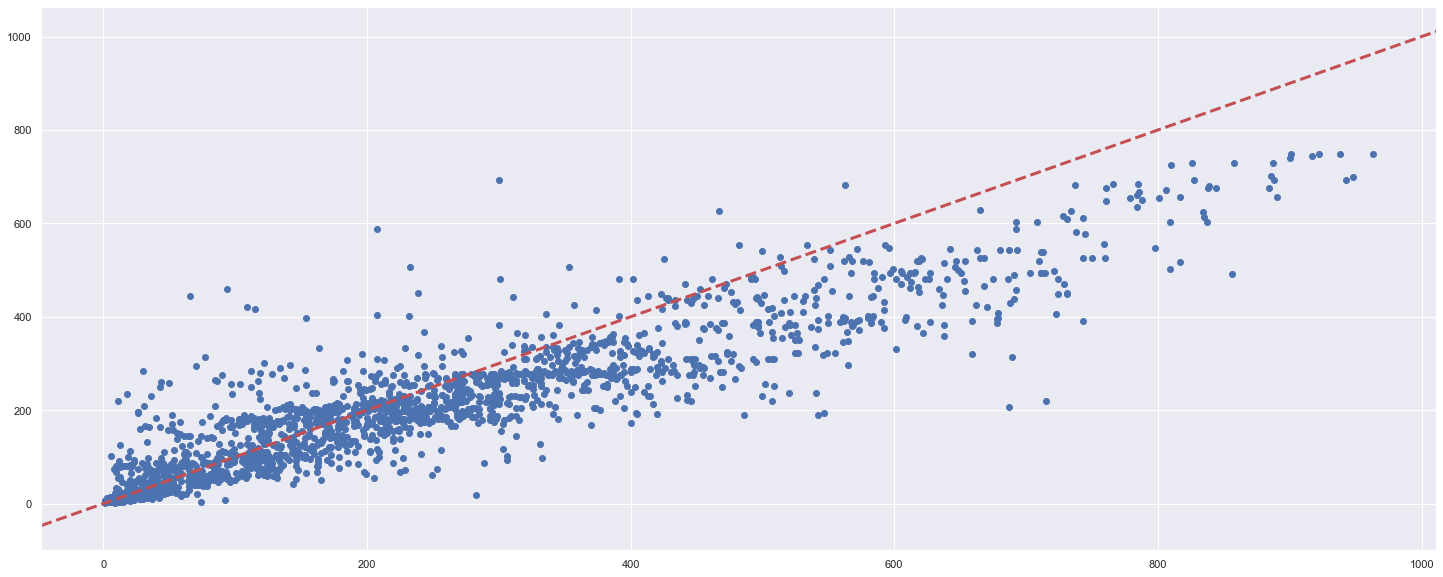

In [62]:
# Plot predictions and actual values on a scatterplot to analyze distribution of residuals
# While having a solid model performance, the plot clearly shows that the model struggles to predict days with higher bike rentals 

fig, ax = plt.subplots(figsize = (25,10))
ax.scatter(np.exp(comparison["cnt"]), np.exp(comparison["predictions"]))

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, scalex = False, color = "r", linestyle = "--", lw = 3)

# transforming log back to real value of rental counts
# setting both axes to the same limit, makes it square
# 100% accuracy of a perfect model
# this is our prediction 

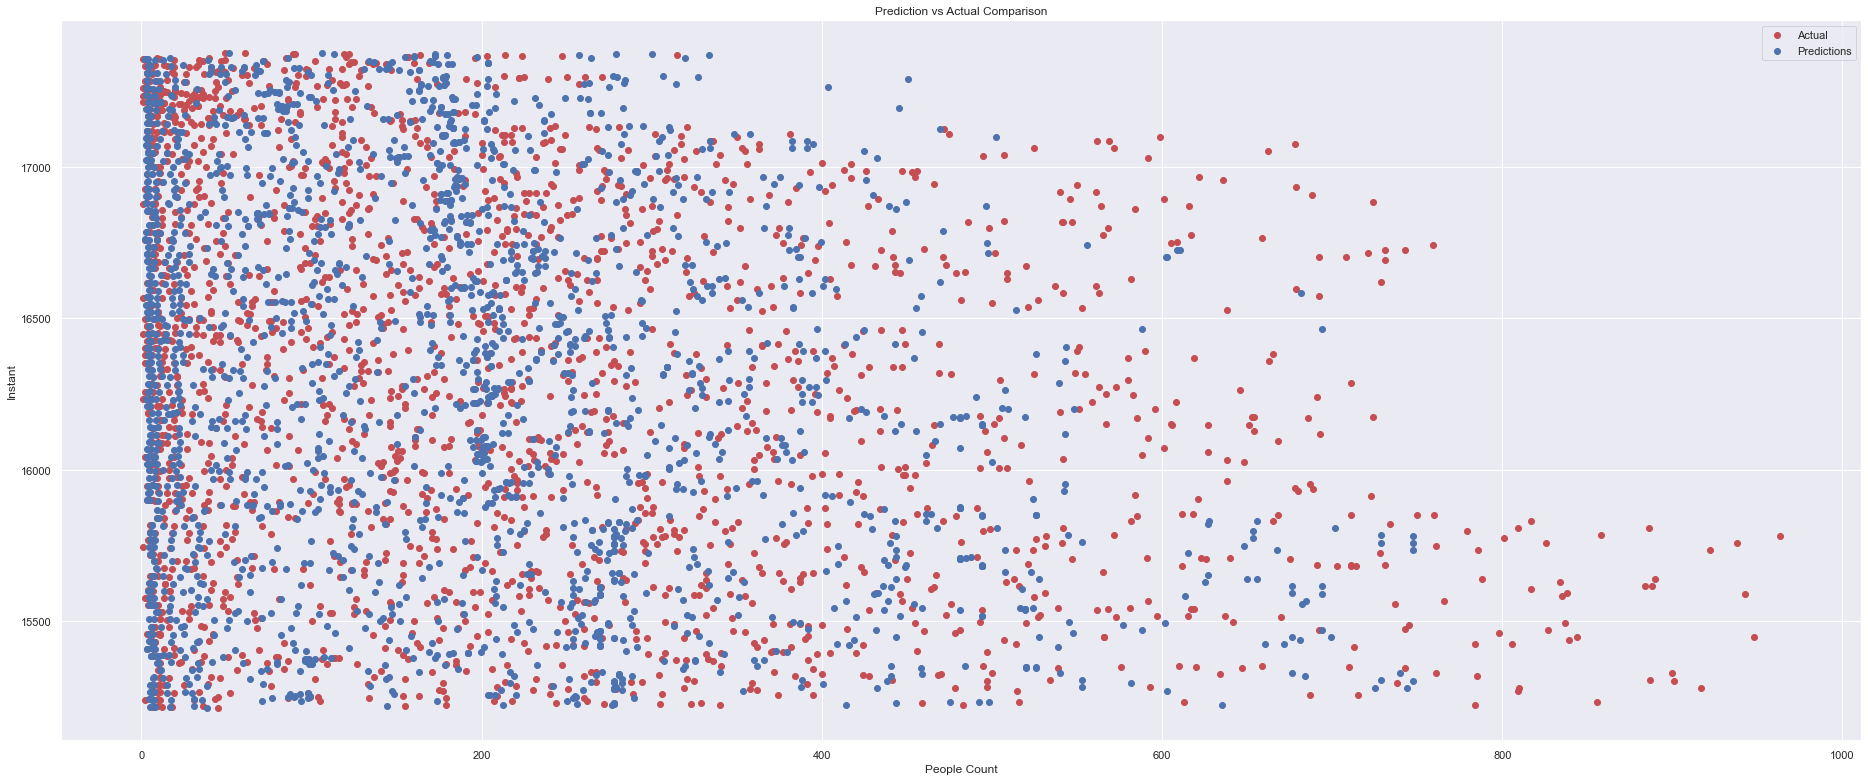

In [63]:
# Plot an additional scatterplot showing both actual and predicted values in different colors
# Again, the higher the daily rentals the fewer predictions can be spotted

actual_scatter = np.exp(comparison["cnt"])
prediction_scatter = np.exp(comparison["predictions"])
grades_range = comparison.index
fig=plt.figure()

fig.set_size_inches(25, 10, forward=True)
ax=fig.add_axes([0,0,1,1])
ax.scatter(actual_scatter, grades_range, color='r', label="Actual")
ax.scatter(prediction_scatter, grades_range, color='b', label="Predictions")
ax.set_xlabel('People Count')
ax.set_ylabel('Instant')
ax.set_title('Prediction vs Actual Comparison')

plt.legend()
plt.show()

#Show actual vs prediction
# Only data points for the last quarter
# not the same scale
# y axis is 
# if everything was perfect youd see no difference
# model under predicts when the counts are above 600
# grades_range only takes index numbers for test
# grades range defines y axis

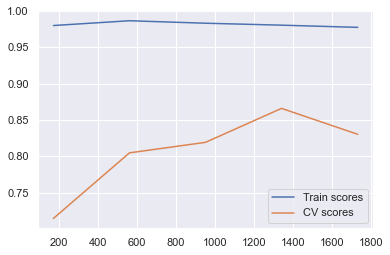

In [64]:
# Finally, the learning curve compares training scores with the CV scores
# With 5-fold cross-validation the optimal score is achieved with around 1350 instances in the test set

# train_sizes separates it in to bins
# for each of them we have a train and test set

train_sizes, train_scores, cv_scores = learning_curve(gs.best_estimator_, X_test, y_test, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train scores")
plt.plot(train_sizes, cv_scores.mean(axis=1), label="CV scores")

plt.legend()

# 